Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
## Using the data by mounting the google drive
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Define paths inside Google Drive for train and test images
data_dir_train = pathlib.Path("/content/drive/My Drive/Skin_cancer_Images/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/Skin_cancer_Images/Test")

# Check if the folders exist
print("Train Directory Exists:", data_dir_train.exists())
print("Test Directory Exists:", data_dir_test.exists())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train Directory Exists: True
Test Directory Exists: True


In [ ]:
#Getiing the image counts for train and test data set
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write Train dataset here
## Use seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,  # 20% of data for validation
  subset="training",  # Load only training data
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write Validation dataset here
## Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,  # Same directory as training (split happens internally)
  seed=123,
  validation_split=0.2,  # 20% of data for validation
  subset="validation",  # Load only validation data
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# Find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

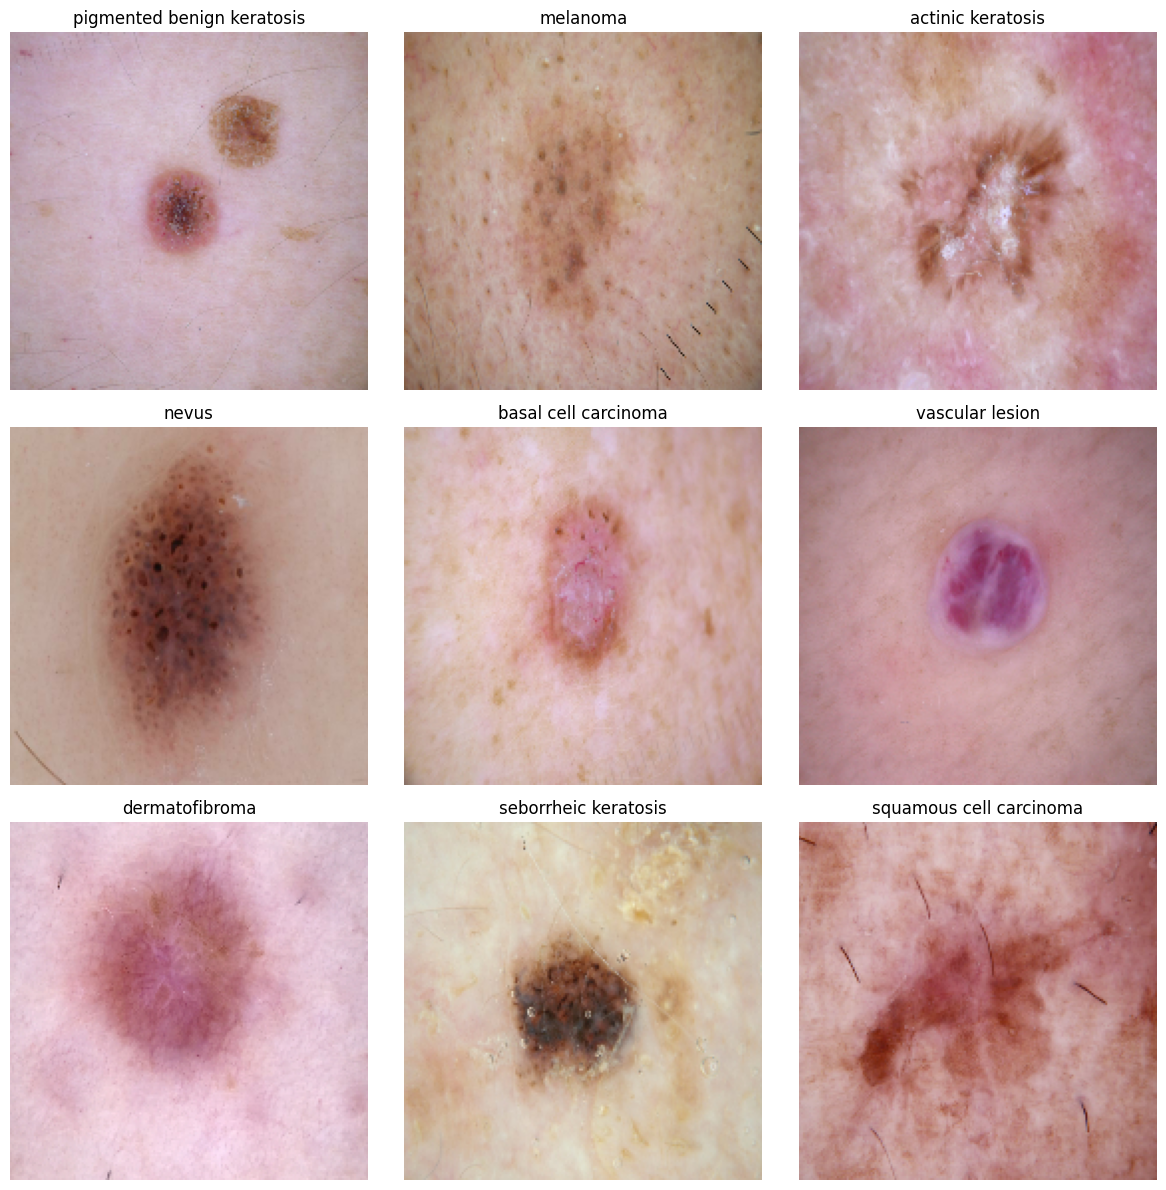

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Dictionary to store one image per class
class_images = {}

# Iterate over multiple batches
for image_batch, label_batch in train_ds:
    for img, label in zip(image_batch, label_batch.numpy()):
        class_name = train_ds.class_names[label]  # Get class name
        if class_name not in class_images:  # Store only one image per class
            class_images[class_name] = img
        if len(class_images) == len(train_ds.class_names):  # Stop when all classes are found
            break
    if len(class_images) == len(train_ds.class_names):
        break

# Plot the images for each class
plt.figure(figsize=(12, 12))
for i, (class_name, img) in enumerate(class_images.items()):
    plt.subplot(3, 3, i + 1)  # Arrange in a 3x3 grid
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset.
Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:

# ✅ Define CNN Model
model = keras.Sequential([
    # Normalize pixel values
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Flatten before passing to dense layers
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevents overfitting
    layers.Dense(9, activation='softmax')  # 9 classes, so softmax activation
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Choose an appropirate optimiser and loss function
✅ Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Since labels are integers
              metrics=['accuracy'])

In [ ]:
# ✅ Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 221s 894ms/step - accuracy: 0.1989 - loss: 2.1643 - val_accuracy: 0.2013 - val_loss: 1.9608
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3232 - loss: 1.9148 - val_accuracy: 0.4497 - val_loss: 1.5697
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4332 - loss: 1.6494 - val_accuracy: 0.4810 - val_loss: 1.4801
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4627 - loss: 1.5168 - val_accuracy: 0.4743 - val_loss: 1.5534
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4800 - loss: 1.4940 - val_accuracy: 0.5011 - val_loss: 1.4699
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4845 - loss: 1.4860 - val_accuracy: 0.4944 - val_loss: 1.4587
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5151 - loss: 1.3858 - val_accuracy: 0.5391 - val_loss: 1.3733
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5257 - loss: 1.3510 - val_accuracy: 0.4765 

### Visualizing training results

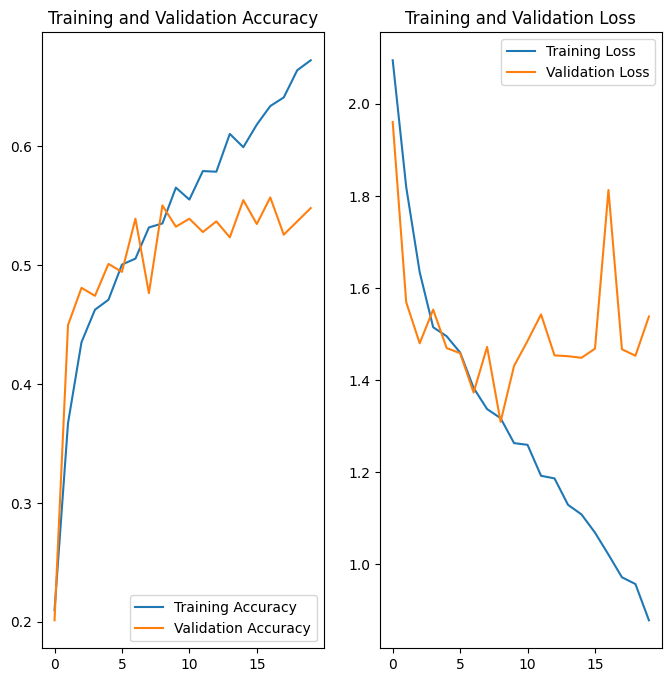

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

# 📝 Findings After Training the CNN Model

## 📊 1️⃣ Accuracy & Loss Trends
- **Training Accuracy**: Started at **~19.8%** and reached **~67.9%** at epoch 20.
- **Validation Accuracy**: Started at **~20.1%** and reached **~54.8%** at epoch 20.
- **Training Loss**: Decreased steadily from **2.16 → 0.86**.
- **Validation Loss**: Fluctuated around **1.4 - 1.5**, without significant improvement.

---

## 🚨 2️⃣ Signs of Overfitting
✅ **Training accuracy is much higher (\~67.9%) than validation accuracy (~54.8%)**  
✅ **Validation loss stops decreasing and fluctuates (~1.4 - 1.8), while training loss keeps improving**  
✅ **Validation accuracy starts plateauing (~50-55%) around epoch 10, but training keeps improving**  

### **Conclusion:**  
⚠ **The model is overfitting** – it's learning the training data well but struggling to generalize to unseen validation data.

---




In [ ]:
# After analysing the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

# ✅ Define Data Augmentation Strategy to Reduce Overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Flip the image horizontally
    layers.RandomRotation(0.2),  # Rotate up to 20%
    layers.RandomZoom(0.2),  # Random zoom up to 20%
    layers.RandomBrightness(0.2),  # Adjust brightness randomly
    layers.RandomContrast(0.2)  # Adjust contrast randomly
])

# ✅ Add this augmentation in model training pipeline to improve generalization.

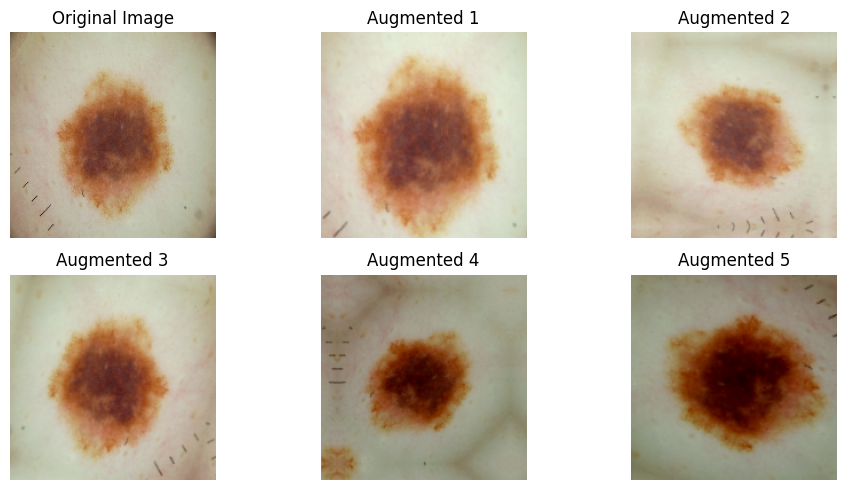

In [ ]:
# Visualize how augmentation strategy works for one instance of training image.
# Load one batch of images from the training dataset
image_batch, label_batch = next(iter(train_ds))

# Select one sample image
sample_image = image_batch[0]

# Plot the original image and 5 augmented versions
plt.figure(figsize=(10, 5))

# Show the original image
plt.subplot(2, 3, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")

# Apply augmentation multiple times and visualize
for i in range(5):
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))  # Expand dims to add batch dimension
    plt.subplot(2, 3, i+2)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(f"Augmented {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Create the model, compile and train the model


In [ ]:
## Use Dropout layer if there is an evidence of overfitting in your findings

# ✅ Define CNN Model with Data Augmentation & Dropout
model = keras.Sequential([
    # Apply data augmentation
    data_augmentation,

    # Normalize pixel values
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.SpatialDropout2D(0.2),  # Drop entire feature maps

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.SpatialDropout2D(0.3),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.SpatialDropout2D(0.4),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Standard dropout for Dense layers
    layers.Dense(9, activation='softmax')  # 9 classes, so softmax activation
])

### Compiling the model

In [ ]:
# ✅ Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Since labels are integers
              metrics=['accuracy'])

In [ ]:
# ✅ Display the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (1, 180, 180, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (1, 90, 90, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (1, 90, 90, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (1, 90, 90, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (1, 45, 45, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (1, 45, 45, 64)             │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (1, 45, 45, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (1, 22, 22, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_2                  │ (1, 22, 22, 128)            │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (1, 61952)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 128)                    │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 9)                      │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.1479 - loss: 2.3991 - val_accuracy: 0.1924 - val_loss: 2.0511
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1853 - loss: 2.0805 - val_accuracy: 0.2506 - val_loss: 2.0057
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.2493 - loss: 2.0020 - val_accuracy: 0.3736 - val_loss: 1.9156
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.2386 - loss: 1.9896 - val_accuracy: 0.3781 - val_loss: 1.7860
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.2645 - loss: 1.9552 - val_accuracy: 0.3691 - val_loss: 1.7797
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2949 - loss: 1.9000 - val_accuracy: 0.4027 - val_loss: 1.8154
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.3213 - loss: 1.8588 - val_accuracy: 0.4183 - val_loss: 1.6906
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3486 - loss: 1.8301 - val_accuracy: 0.4183 - v

### Visualizing the results

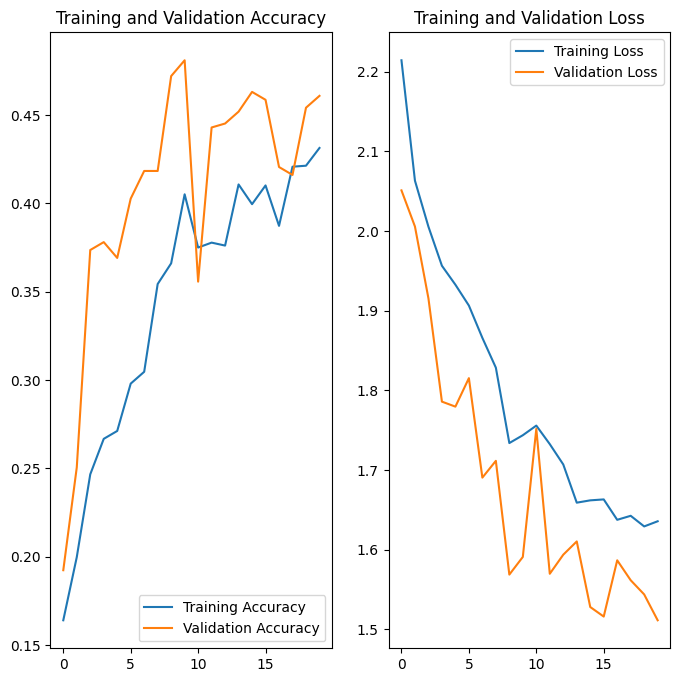

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

# Findings After Model Fit

## 1. First Model Run (Baseline)
- **Training Accuracy:** Reached ~68% by epoch 20.
- **Validation Accuracy:** Reached ~55% by epoch 20.
- **Training Loss:** Decreased steadily to ~0.86.
- **Validation Loss:** Settled around ~1.54.
- **Observation:**  
  - The gap between training and validation accuracy (~13 percentage points) indicates that the model was overfitting.  
  - The model learned the training data well but did not generalize effectively to the validation set.

## 2. Second Model Run (Improved Dropout & Data Augmentation)
- **Training Accuracy:** Reached ~43.8% by epoch 20.
- **Validation Accuracy:** Reached ~46.1% by epoch 20.
- **Training Loss:** Around ~1.64.
- **Validation Loss:** Around ~1.51.
- **Observation:**  
  - The gap between training and validation performance is very small (~2-3 percentage points), suggesting that the overfitting issue has been reduced.
  - However, the overall accuracy is much lower, which indicates that the model may now be underfitting or the regularization (dropout & augmentation) is too aggressive.

## 3. Overall Comparison & Next Steps
- **Improvement:** The second model shows a reduction in overfitting since the training and validation metrics are now much closer.
- **Trade-off:** The significant drop in overall accuracy suggests that the model may be underfitting due to over-regularization.
- **Next Steps:**  
  - Fine-tune the dropout rates and augmentation parameters to find a better balance between reducing overfitting and maintaining sufficient model capacity.
  - Consider increasing the model capacity or training for more epochs if underfitting persists.
  - Experiment with a slight reduction in dropout rates or augmentation intensity to allow the model to learn more complex patterns.

**Conclusion:**  
The improved model with enhanced dropout and data augmentation successfully reduced overfitting, as evidenced by the smaller gap between training and validation performance. However, the overall performance has dropped, indicating potential underfitting. Further tuning is needed to improve accuracy without reintroducing overfitting.


#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
from pathlib import Path

# Get the list of class names from the training directory (assuming each class is a subdirectory)
class_names = sorted([d.name for d in data_dir_train.iterdir() if d.is_dir()])
print("Class names:", class_names)

# Compute the number of images in each class folder
class_counts = {}
for class_name in class_names:
    class_path = data_dir_train / class_name
    count = len([f for f in class_path.iterdir() if f.is_file()])
    class_counts[class_name] = count

# Print the distribution of classes
print("Distribution of classes in the training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Distribution of classes in the training dataset:
actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139


#### Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?
# Findings from Class Distribution Analysis

- **Class with the Least Number of Samples:**  
  - **seborrheic keratosis** has only 77 samples, which is the fewest among all classes.

- **Classes Dominating the Data:**  
  - **pigmented benign keratosis** with 462 samples  
  - **melanoma** with 438 samples  
  - **basal cell carcinoma** with 376 samples  
  - **nevus** with 357 samples  

These classes have proportionately higher numbers of samples, indicating a class imbalance that could impact the model's performance on underrepresented classes.


#Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import os
import Augmentor

# Base path for the training dataset (ensure this is correct and mounted)
path_to_training_dataset = "/content/drive/My Drive/Skin_cancer_Images/Train"

# Loop through each class
for class_name in class_names:
    # Construct the full path for each class
    class_path = os.path.join(path_to_training_dataset, class_name)
    print("Processing:", class_path)  # Optional: Print to verify the path exists

    # Initialize the Augmentor pipeline
    p = Augmentor.Pipeline(class_path)

    # Add rotation augmentation with the specified parameters
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Generate 500 augmented samples for the class
    p.sample(500)

Processing: /content/drive/My Drive/Skin_cancer_Images/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Skin_cancer_Images/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D1CE9963A50>: 100%|██████████| 500/500 [00:17<00:00, 28.67 Samples/s]


Processing: /content/drive/My Drive/Skin_cancer_Images/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Skin_cancer_Images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D1D14185650>: 100%|██████████| 500/500 [00:16<00:00, 29.69 Samples/s]


Processing: /content/drive/My Drive/Skin_cancer_Images/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Skin_cancer_Images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D1D141292D0>: 100%|██████████| 500/500 [00:17<00:00, 28.13 Samples/s]


Processing: /content/drive/My Drive/Skin_cancer_Images/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Skin_cancer_Images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D1D0F56DF90>: 100%|██████████| 500/500 [01:20<00:00,  6.18 Samples/s]


Processing: /content/drive/My Drive/Skin_cancer_Images/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Skin_cancer_Images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7D1D0C2E9950>: 100%|██████████| 500/500 [01:12<00:00,  6.89 Samples/s]


Processing: /content/drive/My Drive/Skin_cancer_Images/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Skin_cancer_Images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D1D0F4A84D0>: 100%|██████████| 500/500 [00:17<00:00, 29.03 Samples/s]


Processing: /content/drive/My Drive/Skin_cancer_Images/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Skin_cancer_Images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D1D14AB2B10>: 100%|██████████| 500/500 [00:37<00:00, 13.19 Samples/s]


Processing: /content/drive/My Drive/Skin_cancer_Images/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Skin_cancer_Images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D1D0C204FD0>: 100%|██████████| 500/500 [00:16<00:00, 30.11 Samples/s]


Processing: /content/drive/My Drive/Skin_cancer_Images/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Skin_cancer_Images/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D1D0F56D810>: 100%|██████████| 500/500 [00:18<00:00, 27.55 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import os
from glob import glob

# Get list of original images (ignoring augmented images stored in the 'output' subfolders)
original_paths = [x for x in glob(os.path.join(str(data_dir_train), '*', '*.jpg')) if 'output' not in x]

# Extract the class labels from the directory structure
original_labels = [os.path.basename(os.path.dirname(x)) for x in original_paths]

# Create a DataFrame for the original training images
original_df = pd.DataFrame({'Path': original_paths, 'Label': original_labels})


# If data_dir_train is a pathlib.Path, convert it to string
path_list = [x for x in glob(os.path.join(str(data_dir_train), '*', 'output', '*.jpg'))]
print(path_list)


['/content/drive/My Drive/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0010516.jpg_63d607c8-1c31-40ec-b879-351d36f6d57f.jpg', '/content/drive/My Drive/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0010148.jpg_13e293cc-cc43-49cb-b30f-87278282b98f.jpg', '/content/drive/My Drive/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0000462.jpg_3adef9cf-73cc-4623-89b8-efbb63d4ae37.jpg', '/content/drive/My Drive/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0000314.jpg_a53428e7-1044-455e-9d28-a172d35b6ecf.jpg', '/content/drive/My Drive/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0010766.jpg_87f2dedc-89d0-4c52-b65c-f9cf1464d209.jpg', '/content/drive/My Drive/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0010609.jpg_346b6464-3262-4d1e-af93-6ecb280f499f.jpg', '/content/drive/My Drive/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0010965.jpg_5f0bc84d-b44c-4ca3-b143-321ee66c03

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [ ]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",  # This ensures that only the training portion is loaded.
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",  # Load only validation data
  image_size=(img_height, img_width),
  batch_size=batch_size)


Create your model (make sure to include normalization)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Define the CNN model with Batch Normalization
model = models.Sequential([
    # Normalize pixel values from [0, 255] to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),  # Batch Normalization layer
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    # Flatten the output to feed into Dense layers
    layers.Flatten(),

    # Dense Layers
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')  # 9 classes for classification
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


#### Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - accuracy: 0.2778 - loss: 2.3496 - val_accuracy: 0.1499 - val_loss: 21.3339
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 178ms/step - accuracy: 0.4578 - loss: 1.5581 - val_accuracy: 0.1275 - val_loss: 15.4747
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 174ms/step - accuracy: 0.5345 - loss: 1.3132 - val_accuracy: 0.2640 - val_loss: 3.2891
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.4996 - loss: 1.3730 - val_accuracy: 0.5526 - val_loss: 1.3044
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.6124 - loss: 1.0841 - val_accuracy: 0.6443 - val_loss: 1.1340
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.6558 - loss: 0.9716 - val_accuracy: 0.5548 - val_loss: 1.2322
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.7167 - loss: 0.7933 - val_accuracy: 0.6421 - val_loss: 1.0296
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 180ms/step - accuracy: 0.7472 - loss:

#### **Todo:**  Visualize the model results

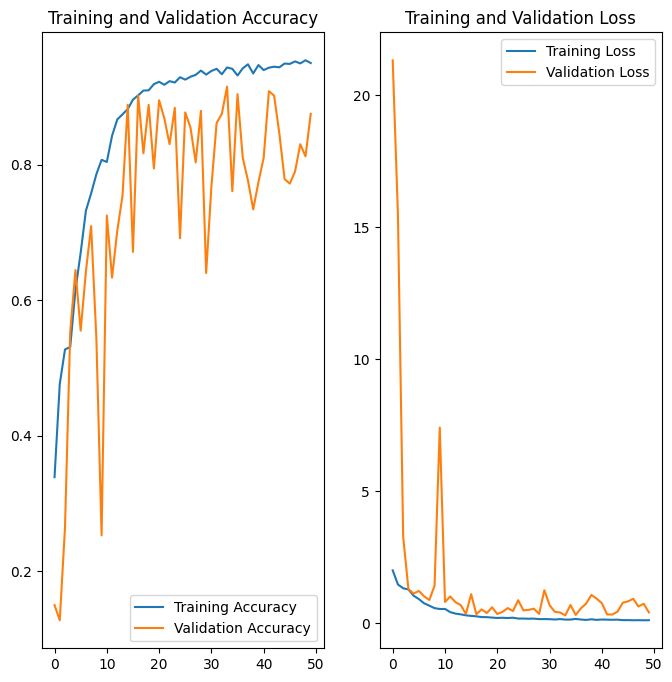

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

# Analysis of Model Training Results

### Overall Observations
- **Early Epochs (Epochs 1–3):**  
  The model started with low training accuracy (∼28–54%) and very high validation losses, indicating that initial predictions were poor and unstable.

- **Mid Training (Epochs 4–17):**  
  - The training accuracy steadily increased, reaching nearly 90% by epoch 17.
  - The validation accuracy also improved substantially, with some epochs (e.g., epoch 4 and 15) showing validation accuracy above 55–88%.
  - The gap between training and validation performance narrowed, suggesting that overfitting was reduced.
  
- **Later Epochs (Epochs 18–50):**  
  - Training accuracy reached a high plateau (around 93–95%).
  - Validation accuracy fluctuated between ∼70% and ∼91%, with several epochs (e.g., 34, 42, 43) achieving validation accuracies above 90%.
  - Overall, the model appears to have learned the training data very well while still generalizing reasonably to the validation data.

### On Underfitting and Overfitting
- **Underfitting:**  
  The model does not seem to be underfitting because training accuracy consistently reaches high values (over 90%) in later epochs.

- **Overfitting:**  
  Although the training accuracy is very high, the gap between training and validation accuracy is modest at many points. However, validation accuracy does fluctuate across epochs, which suggests that while major overfitting has been reduced, the model’s generalization is still not entirely stable.  
  - **Key Observation:**  
    In earlier models, there was a much larger gap between training and validation metrics. With the current strategy (including dropout, batch normalization, and class rebalance through augmentation), the metrics are much closer – a positive sign that overfitting has been mitigated.

### Effect of Class Rebalance via Augmentation
- **Class Rebalance Impact:**  
  By augmenting each class with 500 additional images, the dataset became more balanced. This is expected to help the model learn more equally from all classes, improving its ability to generalize.
  - The improved and more consistent validation performance in several epochs suggests that the augmented (and thus rebalanced) data has helped the model avoid being biased toward classes with more samples.
  
### Final Takeaways
- **Improvement:**  
  The combination of dropout, batch normalization, and class rebalancing has reduced overfitting compared to the initial model run. Training and validation accuracies are much closer, and validation performance improved significantly (with best values reaching above 90% in some epochs).

- **Remaining Variability:**  
  Despite the improvements, validation accuracy still fluctuates across epochs, indicating that there might still be room for further tuning (e.g., fine-tuning dropout rates, adjusting augmentation parameters, or experimenting with additional regularization).

- **Conclusion:**  
  Overall, the current model demonstrates a better balance between learning the training data and generalizing to unseen data. The class rebalancing strategy appears to have helped improve performance, as evidenced by the improved and less biased validation accuracy. Further fine-tuning may yield even more consistent performance.



